<div style="background-color: #eee3d3">
<h1> 5-first_classification_models.ipynb </h1>
</div>

---

### The purpose of this notebook is to test a few different models on our dataset

The ultimate goal of this project is to find potential biomarkers, i.e. which variables (peak table columns) have the strongest ability to separate the two sample groups (Incident vs. Non-case).

To find potential biomarkers, you can find a subset of the peak table columns which have a strong ability to predict the __group sample__, Incident or Non-case (classification). For that, you will find in this notebook a first draft of a few machine learning models tested on our data.

---

In this notebook, we expect you to :
- use proposed methods below
- use other classification methods (logistic regression model for example)
- choose a quantitative criterion to assess the classification quality and explain why you did this choice
- create plots

---

After this notebook, you can create another one presenting which variables (peak table columns) could be potential biomakers based on your analysis in these notebooks.

Once again, feel free to add anything that you find relevant to find potential biomakers.

__Good luck for this project :)__

---

## Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
np.random.seed(12345678)

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression

In [3]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, recall_score
from sklearn.model_selection import learning_curve

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import glob
import os

## Define useful functions for the analysis

In [6]:
def evaluation(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, scoring='f1', train_sizes=np.linspace(0.1, 1, 10))
    
    fig = plt.figure(figsize=(12,8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    display(fig)
    plt.legend()

In [7]:
def pipeline(missing_cols):
    
    # We need to have the tables with missing values/normalisation (and demensional reduction if possible) done
    # with the best methods each time.
    
    for normalized_peakTable_file in glob.glob('../data/peakTable/scaled_peak_tables/au*.csv'):
        
        print(200*'-')
        print(20*'-', normalized_peakTable_file)
        print(200*'-')
        
        # Import normalized peakTable
        peakTable_normalized = pd.read_csv(normalized_peakTable_file, sep=',')
        peakTable_normalized = peakTable_normalized.iloc[: , 1:] # We had a column with the index appear on normalisation step
        
        # Add the first columns that were missing
        peakTable_normalized = pd.concat([missing_cols, peakTable_normalized], axis=1)
        
        # Split into train and test sets
        code = {'Incident':1,'Non-case':0}
        y = peakTable_normalized['Groups']
        y = y.map(code)
        X = peakTable_normalized.iloc[:,2:]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,test_size=0.2, random_state=0, stratify=y)
        
        # Create and evaluate models
        prepocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))
        
        RandomForest = make_pipeline(prepocessor, RandomForestClassifier(random_state=0))
        AdaBoost = make_pipeline(prepocessor, AdaBoostClassifier(random_state=0))
        SVM = make_pipeline(prepocessor, StandardScaler(), SVC(random_state=0))
        KNN = make_pipeline(prepocessor, StandardScaler(), KNeighborsClassifier())
        
        dict_models = {'RandomForest': RandomForest,
               'AdaBoost' : AdaBoost,
               'SVM': SVM,
               'KNN': KNN,
               'LogisticRegression' : LogisticRegression # Doesn't work yet ...
              }
        
        for name, model in dict_models.items():
            print(name)
            evaluation(model, X_train, X_test, y_train, y_test)
            print(100*'-')
          
        
        print(3*'\n')

In [8]:
# We missed the first columns that we needed for the pipeline for every table
path_peakTable = '/'.join(os.getcwd().split('/')[:-1]) + '/data/peakTable/original_peak_table/peakTable_HILIC_POS.csv'
peakTable = pd.read_csv(path_peakTable, sep=',', decimal='.', na_values='NA')
first_cols = peakTable.iloc[:,:2]

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------- ../data/peakTable/scaled_peak_tables/autoscaling.csv
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
RandomForest
[[17  2]
 [ 8 11]]
              precision    recall  f1-score   support

           0       0.68      0.89      0.77        19
           1       0.85      0.58      0.69        19

    accuracy                           0.74        38
   macro avg       0.76      0.74      0.73        38
weighted avg       0.76      0.74      0.73        38



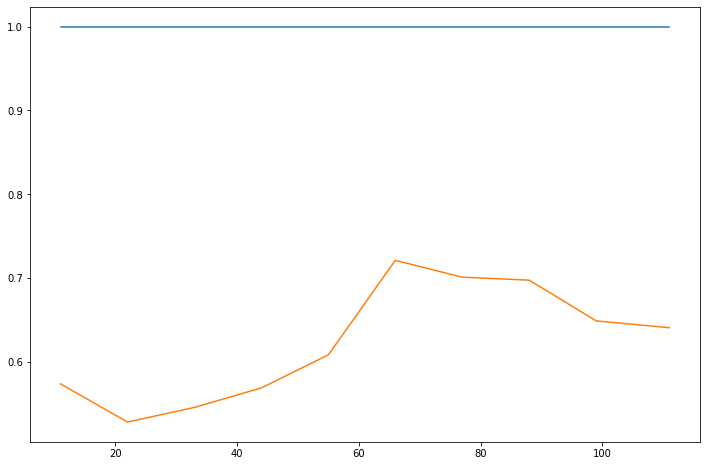

----------------------------------------------------------------------------------------------------
AdaBoost


KeyboardInterrupt: 

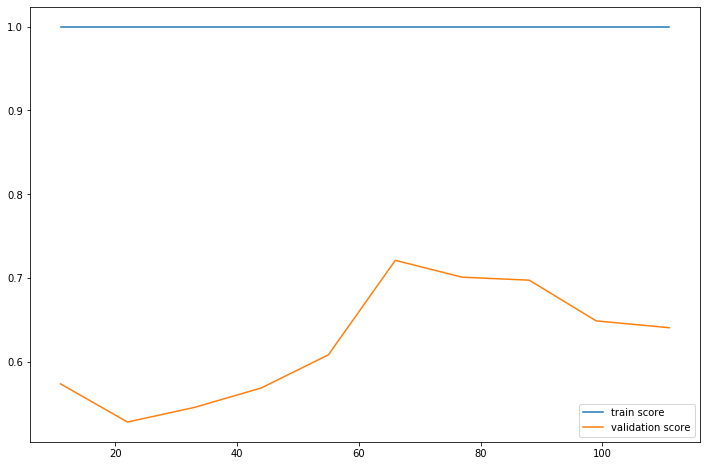

In [9]:
pipeline(first_cols)